# 作業
請使用不同的資料集，並使用 hyper-parameter search 的方式，看能不能找出最佳的超參數組合

### import 所需套件

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import warnings
warnings.simplefilter('ignore')
% matplotlib inline
import time

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.pipeline import Pipeline

### 定義繪製confusion matrix的function

In [11]:
def plot_confusion_matrix(confmat, target_names=None, title=None):
    plt.matshow(confmat, cmap=plt.cm.Blues, alpha=0.7)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            plt.text(x=j,y=i, s=f'{confmat[i][j]}',va='center',ha='center')
    
    if target_names is not None:
        plt.xticks(np.arange(len(target_names)),target_names)
        plt.yticks(np.arange(len(target_names)),target_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.grid('off')
    plt.tight_layout()
    plt.savefig('fig.png', dpi=300, transparent =False, bbpx_inches='tight')

### Gradient Boosting for Classification Problem

accuracy with default hyperparameters: 0.962


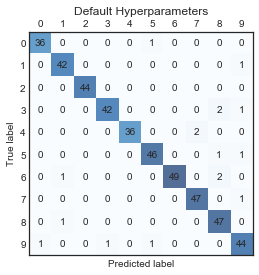

In [12]:
# 讀取手寫辨識資料集
digits = datasets.load_digits()

# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=0)

# 建立模型
gbc = GradientBoostingClassifier()

# 將訓練資料丟入模型訓練
gbc.fit(x_train, y_train)

# 將測試資料丟入模型取得預測結果
y_pred = gbc.predict(x_test)

# 利用accuracy評估模型預測結果
print(f'accuracy with default hyperparameters: {metrics.accuracy_score(y_test, y_pred):.3f}')

# 繪製 confusion matrix
confmat = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat, target_names = digits.target_names, title = "Default Hyperparameters")

In [13]:
# 設定要訓練的超參數組合
n_estimators = [100, 200, 300]
max_depth = [1, 3, 5]
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth,min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(gbc, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)

# 開始搜尋最佳參數
time_start = time.time()
grid_result = grid_search.fit(x_train, y_train)

print(f'Best accuracy: {grid_result.best_score_:.3f}')
print(f'Best parameters:{grid_result.best_params_}')
print(f"Average time to fit: {grid_result.cv_results_['mean_fit_time'].mean():.3f}")
print(f"Average time to predict: {grid_result.cv_results_['mean_score_time'].mean():.3f}")
print(f"Time elapsed = {time.time() - time_start} (sec)")

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  2.4min finished


Best accuracy: -0.713
Best parameters:{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}
Average time to fit: 4.563
Average time to predict: 0.016
Time elapsed = 146.7847285270691 (sec)


Testing accuracy = 0.960


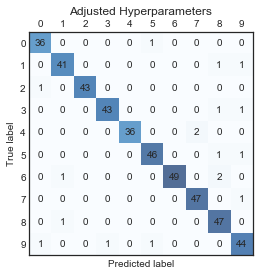

In [14]:
gbc = GradientBoostingClassifier(max_depth=grid_result.best_params_['max_depth'], n_estimators=grid_result.best_params_['n_estimators'],min_samples_split= grid_result.best_params_['min_samples_split'],min_samples_leaf=grid_result.best_params_['min_samples_leaf'])
gbc.fit(x_train, y_train)
y_pred = gbc.predict(x_test)
print(f"Testing accuracy = {metrics.accuracy_score(y_test, y_pred):.3f}")
confmat = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat, target_names = digits.target_names, title = "Adjusted Hyperparameters")

### 調參結果竟然比原本差一點點